# Prédiction de diabète

### Introduction

###### L'objectif de ce projet est de pouvoir au final prédire avec un modèle de classification "la probabilité d'avoir un diabète de type II". Le dataset comporte 8 colonnes et 100000 lignes. Les variables sont : sexe, age, hypertension, maladie de coeur, historique de fumeur, IMC, niveau glycémique, taux de glucose dans le sang et la target est : diabètes

### Sommaire

Installation des bibliothèques utilisées

I. Chargement du dataset

II. Prétraitement
1. On enlève les doublons
2. Remplacer les valeurs char par des valeur int avec LabelEncoder
3. Supprimer certains éléments du dataset
4. Combler les valeurs manquantes en utilisant 'imputer' de sklearn ou manuellement en fonctions des proportions
5. Normalisation des données
6. Oversampling et Undersampling
7. Affichage de la matrice de corrélation (Permière visualisation)
8. Explication

III. 1er Modèle avec une phase d’apprentissage et une phase de test
1. Phase d'apprentissage & de test
2. Sélection du meilleur hyperparamètre
3. Validations croisés avec 5 plis & importance de chaque variables
4. Savoir si on est en overfitting ou underfitting 
5. Explication

IV. Pipeline
1. Diviser les données en ensembles d'entraînement et de test
2. Créer des pipelines pour différentes méthodes de classification
3. Entraîner et évaluer chaque modèle avec la validation croisée
4. Comparaison des différentes méthodes de classification
5. Explication

V. Analyse des données et résultats
1. Confusion matrice, ROC Curve, importance features, F1 score aveec recall & précision 
2. Explication

VI. Axes d'améliorations
1. Savoir quel est le meilleur pourcentage de dégradations

# Installation des bibliothèques utilisées

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
import tqdm as tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import numpy as np

In [9]:
pip install -U imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


# I. Chargement du dataset

In [10]:
from pandas import read_csv

In [11]:
data = read_csv('diabetes_prediction_dataset.csv') #récolte des datas
print(data) # affichage du dataset
print(data['diabetes'].value_counts()) # affichage du nombre de target = à 1 et = à 0

       gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
1      Female  54.0             0              0         No Info  27.32   
2        Male  28.0             0              0           never  27.32   
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
...       ...   ...           ...            ...             ...    ...   
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          former  27.83   
99998  Female  24.0             0              0           never  35.42   
99999  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                  140        

#  II. Pré-traitement (normalisation, nettoyage, encodage ...)

### 1. On enlève les doublons

In [12]:
# Suppression des doublons
data = data.drop_duplicates()
print(data.shape)

(96146, 9)


### 2. Remplacer les valeurs char par des valeur int avec LabelEncoder

In [13]:
from sklearn.preprocessing import LabelEncoder

# Conversion de toutes les valeurs de la colonne 'gender' & 'smoking_history en chaînes de caractères car c'est des char
data['gender'] = data['gender'].astype(str)
data['smoking_history'] = data['smoking_history'].astype(str)

# Création d'une instance de l'objet LabelEncoder pour la colonne 'gender' & la colonne 'smoking_history'
encoder_gender = LabelEncoder()
encoder_smoking = LabelEncoder()

# Application de l'encodage aux valeurs de la colonne 'gender' & 'smoking_history'
# L'encodeur est ajusté (fit_transform) pour mapper les valeurs uniques à des entiers
data['gender'] = encoder_gender.fit_transform(data['gender'])
# L'encodeur est ajusté pour mapper les valeurs uniques à des entiers
data['smoking_history'] = encoder_smoking.fit_transform(data['smoking_history'])

print(data['gender']+data['smoking_history'])

0        4
1        0
2        5
3        1
4        2
        ..
99994    0
99996    0
99997    4
99998    4
99999    1
Length: 96146, dtype: int32


### 3. Supprimer certains éléments du dataset

In [14]:
# Pour chaque éléments d'une ligne on a 10% de chance qu'il se fasse supprimer
percentage_to_remove = 5

# Générez un masque aléatoire pour les éléments à supprimer
mask = np.random.rand(*data.shape) < (percentage_to_remove / 100)

# Remplacement des valeurs sélectionnées par des données indéterminées
data[mask] = np.nan

print(data)

       gender   age  hypertension  heart_disease  smoking_history    bmi  \
0         NaN  80.0           0.0            1.0              4.0  25.19   
1         0.0  54.0           0.0            0.0              0.0  27.32   
2         1.0  28.0           0.0            0.0              4.0  27.32   
3         0.0  36.0           0.0            0.0              1.0  23.45   
4         1.0  76.0           1.0            1.0              1.0  20.14   
...       ...   ...           ...            ...              ...    ...   
99994     0.0  36.0           0.0            0.0              0.0  24.60   
99996     0.0   2.0           0.0            0.0              0.0  17.37   
99997     1.0  66.0           0.0            0.0              3.0  27.83   
99998     0.0  24.0           0.0            0.0              4.0  35.42   
99999     0.0  57.0           0.0            0.0              1.0  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                1

### 4. Combler les valeurs manquantes en utilisant 'imputer' de sklearn ou manuellement en fonctions des proportions

In [15]:
## Remplacement des données binaires dans gender par la proportion de F et de H avant implémentation
def impute_with_proportions(data, column_name):
    # Calculer les pourcentages de 1 et de 0 dans la colonne
    proportions = data[column_name].value_counts(normalize=True)
    
    if len(proportions) == 0:
        # Aucune valeur unique dans la colonne
        return
    
    p_1 = proportions.loc[1] if 1 in proportions.index else 0
    p_0 = proportions.loc[0] if 0 in proportions.index else 0

    # Vérifier si la somme des proportions est égale à zéro
    if p_1 + p_0 == 0:
        # Aucune valeur dans la colonne
        return

    # Normaliser les pourcentages pour qu'ils ajoutent à 1
    total = p_1 + p_0
    normalized_percentage_1 = p_1 / total
    normalized_percentage_0 = p_0 / total

    # Imputer les valeurs manquantes dans la colonne en utilisant les pourcentages calculés
    mask_missing = data[column_name].isnull()
    data.loc[mask_missing, column_name] = np.random.choice([1, 0], size=mask_missing.sum(), p=[normalized_percentage_1, normalized_percentage_0])
    
# Liste des colonnes à traiter (valeur binaire)
columns_to_impute = ['gender', 'heart_disease', 'diabetes']

# Appliquer la fonction pour chaque colonne
for column in columns_to_impute:
    impute_with_proportions(data, column)

# Créer une fonction d'imputation personnalisée
def imputer_colonne(colonne): # 2 stratégies utilisés, 1 pour les colonnes comportant des entiers 'most_frequent'  et une pour les floats 'mean'
    if colonne.name in ['age', 'hypertension', 'smoking_history', 'blood_glucose_level']: 
        return SimpleImputer(strategy='most_frequent').fit_transform(colonne.values.reshape(-1, 1)).ravel() #'most_frequent' (la valeur la plus fréquente dans la colonne)
    else:
        return SimpleImputer(strategy='mean').fit_transform(colonne.values.reshape(-1, 1)).ravel() #'mean' (la valeur moyenne de la colonne)

# Appliquer l'imputation aux colonnes
data = data.apply(imputer_colonne)

# Afficher le tableau après l'imputation
print(data)

       gender   age  hypertension  heart_disease  smoking_history    bmi  \
0         1.0  80.0           0.0            1.0              4.0  25.19   
1         0.0  54.0           0.0            0.0              0.0  27.32   
2         1.0  28.0           0.0            0.0              4.0  27.32   
3         0.0  36.0           0.0            0.0              1.0  23.45   
4         1.0  76.0           1.0            1.0              1.0  20.14   
...       ...   ...           ...            ...              ...    ...   
99994     0.0  36.0           0.0            0.0              0.0  24.60   
99996     0.0   2.0           0.0            0.0              0.0  17.37   
99997     1.0  66.0           0.0            0.0              3.0  27.83   
99998     0.0  24.0           0.0            0.0              4.0  35.42   
99999     0.0  57.0           0.0            0.0              1.0  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                1

### 5. Normalisation des données

In [16]:
# Sélectionner toutes les colonnes sauf la dernière
data_to_normalize = data.iloc[:, :-1]  # Sélection de toutes les colonnes sauf la dernière

# Normalisation des données sauf la dernière colonne
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_to_normalize)

# Reconstruire le DataFrame avec les données normalisées
data_normalized_df = pd.DataFrame(data_normalized, columns=data_to_normalize.columns)

# Ajouter la dernière colonne non normalisée au DataFrame normalisé
data_normalized_df['diabetes'] = data['diabetes']

# Assigner le DataFrame normalisé à la variable data
data = data

# Afficher le DataFrame normalisé
print(data)


       gender   age  hypertension  heart_disease  smoking_history    bmi  \
0         1.0  80.0           0.0            1.0              4.0  25.19   
1         0.0  54.0           0.0            0.0              0.0  27.32   
2         1.0  28.0           0.0            0.0              4.0  27.32   
3         0.0  36.0           0.0            0.0              1.0  23.45   
4         1.0  76.0           1.0            1.0              1.0  20.14   
...       ...   ...           ...            ...              ...    ...   
99994     0.0  36.0           0.0            0.0              0.0  24.60   
99996     0.0   2.0           0.0            0.0              0.0  17.37   
99997     1.0  66.0           0.0            0.0              3.0  27.83   
99998     0.0  24.0           0.0            0.0              4.0  35.42   
99999     0.0  57.0           0.0            0.0              1.0  22.43   

       HbA1c_level  blood_glucose_level  diabetes  
0              6.6                1

### 6. Oversampling et Undersampling

###### La normalisation des données donne des résultats plus qu'insatisfaisant c'est pourquoi je la met de coté

In [17]:
# Diviser le jeu de données en X et y
X = data.drop('diabetes', axis=1)
y = data['diabetes']

# Utiliser RandomOverSampler pour effectuer l'oversampling
oversampler = RandomOverSampler(random_state=42)
X_over, y_over = oversampler.fit_resample(X, y)

# Utiliser RandomUnderSampler pour effectuer l'undersampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

# Créer un nouveau DataFrame avec les données rééquilibrées
data_balanced = pd.DataFrame(X_over, columns=X.columns)
data_balanced['diabetes'] = y_over  # Ajouter la colonne de la variable cible

# Concaténer le DataFrame rééquilibré avec le DataFrame original
data = pd.concat([data, data_balanced], ignore_index=True)


### 7. Affichage de la matrice de corrélation (Permière visualisation)

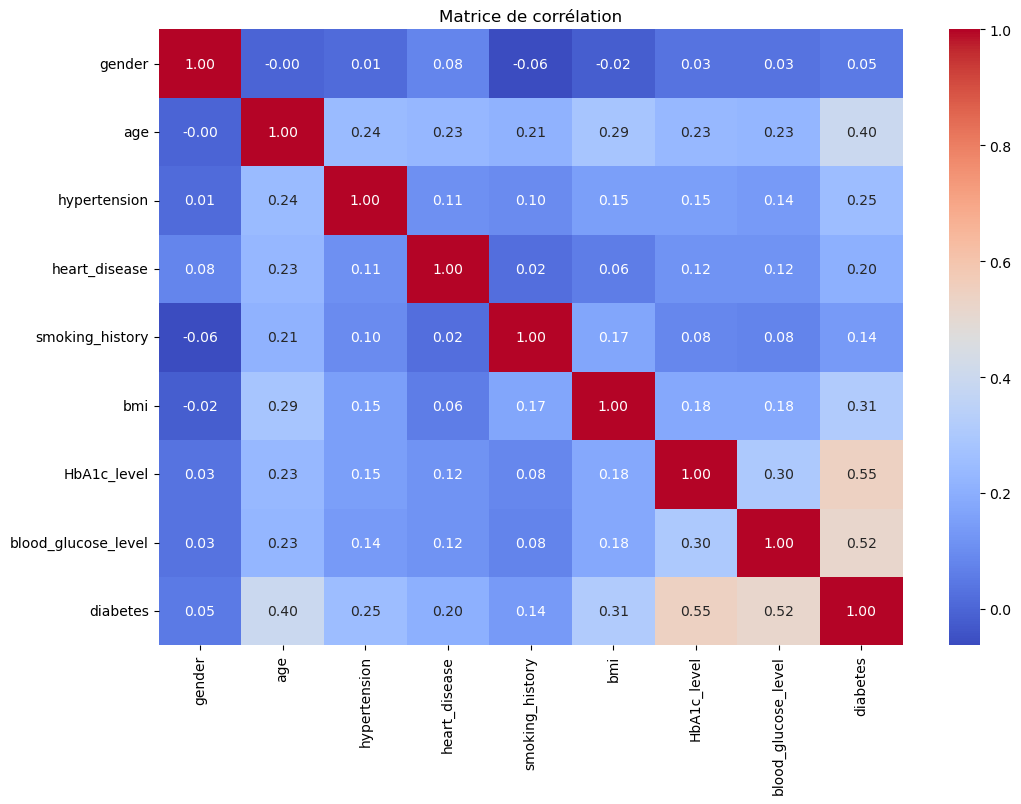

In [18]:
# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

### 8. Explication : 

Partie I : Chargement du dataset

Pour commencer notre projet de prédiction du diabète, nous devons d'abord charger notre ensemble de données. Nous utilisons la bibliothèque Pandas pour cela qui sert pour la manipulation et l'analyse de données tabulaires. Nous lisons le fichier CSV contenant nos données à l'aide de la fonction read_csv de Pandas. Après avoir chargé les données, nous affichons brièvement un aperçu du dataset pour comprendre sa structure et ses caractéristiques à l'aide de la fonction print. De plus, nous affichons le nombre de valeurs cibles égales à 1 et à 0 dans la colonne 'diabetes' pour avoir une idée de la distribution de notre variable cible.
    
Après avoir chargé les données, nous passons à la partie de prétraitement.

Partie II : Pré-traitement des données

1. Suppression des doublons

La première étape du pré-traitement consiste à supprimer les doublons éventuels dans le jeu de données. Les doublons peuvent fausser nos analyses et nos modèles en introduisant des redondances indésirables. Nous utilisons la fonction drop_duplicates de Pandas pour cette tâche.

2. Encodage des valeurs catégorielles

Nous rencontrons souvent des données catégorielles dans nos ensembles de données. Pour les utiliser dans des algorithmes d'apprentissage automatique, nous devons les convertir en une forme numérique. Nous utilisons l'encodage des étiquettes (LabelEncoder) de la bibliothèque Scikit-Learn pour accomplir cette tâche. Ici, nous convertissons les colonnes 'gender' et 'smoking_history' de nos données en valeurs numériques.

3. Suppression d'éléments aléatoires

Nous choisissons de supprimer certains éléments du dataset de manière aléatoire. Pour chaque élément de chaque ligne, il y a une probabilité de 10% qu'il soit supprimé. Nous utilisons une approche basée sur un masque aléatoire pour effectuer cette opération.

4. Imputation des valeurs manquantes

Après avoir introduit des valeurs manquantes de manière aléatoire, nous devons les traiter. Nous avons deux approches pour cela :

4.1 Imputation basée sur les proportions

    Pour les colonnes binaires telles que 'gender', 'heart_disease' et 'diabetes', nous imputons les valeurs manquantes en fonction des proportions des valeurs existantes dans la colonne. Nous utilisons une fonction personnalisée impute_with_proportions pour réaliser cette tâche.
    
4.2 Imputation par stratégie

    Pour les colonnes contenant des valeurs numériques, nous utilisons deux stratégies différentes pour l'imputation. Pour les colonnes 'age', 'hypertension', 'smoking_history' et 'blood_glucose_level', nous utilisons la stratégie 'most_frequent', qui remplace les valeurs manquantes par la valeur la plus fréquente dans la colonne. Pour les autres colonnes telles que 'bmi' et 'HbA1c_level', nous utilisons la stratégie 'mean', qui remplace les valeurs manquantes par la moyenne de la colonne.
    
5. Normalisation des données

La normalisation des données est une étape essentielle pour garantir des performances optimales des algorithmes d'apprentissage automatique. Nous utilisons la standardisation des données (StandardScaler) pour mettre à l'échelle les valeurs numériques. Cela permet d'attribuer une importance égale à toutes les caractéristiques.
    
6. Sur-échantillonnage et sous-échantillonnage

Le déséquilibre de classe est un problème courant dans les ensembles de données où une classe est beaucoup plus fréquente que les autres. Pour remédier à cela, nous pouvons utiliser des techniques de sur-échantillonnage et de sous-échantillonnage.

6.1 Sur-échantillonnage

    Nous utilisons RandomOverSampler pour augmenter le nombre d'échantillons de la classe minoritaire, dans notre cas, la classe diabète. Cela aide à équilibrer les classes et à améliorer les performances des modèles sur les données déséquilibrées.
    
6.2 Sous-échantillonnage

    Nous utilisons RandomUnderSampler pour réduire le nombre d'échantillons de la classe majoritaire. Cela peut aider à réduire le temps d'entraînement et à éviter le surajustement aux données majoritaires.

7. Visualisation de la matrice de corrélation

Avant de passer à la modélisation, il est souvent utile de visualiser la matrice de corrélation entre les caractéristiques. Cela nous aide à identifier les relations linéaires entre les variables et à éliminer les caractéristiques fortement corrélées, ce qui peut améliorer les performances des modèles.

Conclusion 
En combinant toutes ces étapes de prétraitement, nous avons préparé nos données pour l'entraînement des modèles de prédiction du diabète.

#  III. 1er Modèle avec une phase d’apprentissage et une phase de test

## Modèle : RandomForestClassifier

### 1. Phase d'apprentissage & de test

Accuracy: 0.997145645728597
Confusion Matrix:
[[34817   148]
 [    7 19331]]


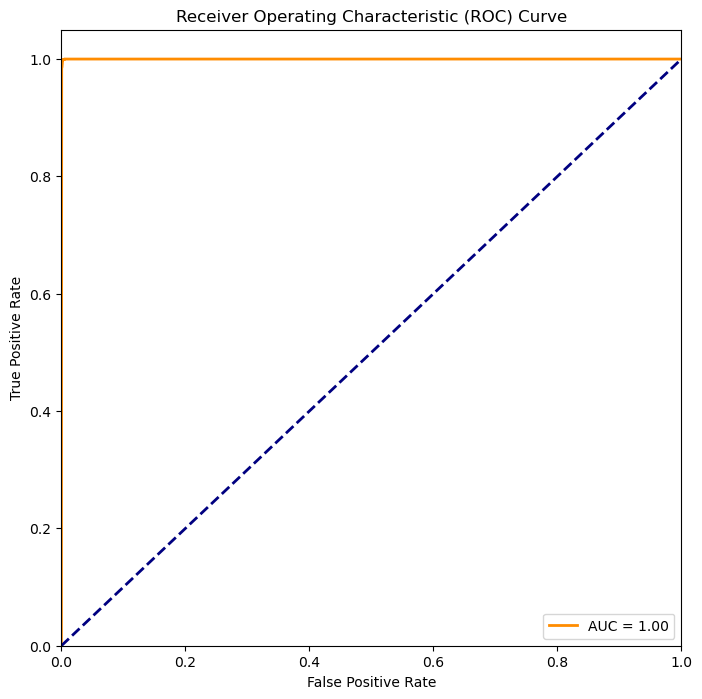

In [19]:
# Liste des colonnes à traiter (valeur binaire)
columns_to_impute = ['gender', 'heart_disease', 'diabetes']

# Appliquer la fonction pour chaque colonne
for column in columns_to_impute:
    impute_with_proportions(data, column)

# Imputer les valeurs manquantes dans la colonne "diabetes" en utilisant les proportions
impute_with_proportions(data, 'diabetes')

# Diviser les données en ensembles d'entraînement et de test
X = data.drop('diabetes', axis=1)
y = data['diabetes']
X_train, X_test, y_train, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle
model = RandomForestClassifier(random_state=42)

# Phase d'apprentissage
model.fit(X_train, y_train)

# Phase de test
y_pred_rf = model.predict(X_test)
y_prob_rf = model.predict_proba(X_test)[:, 1]

# Affichage du score
accuracy = accuracy_score(y_test_rf, y_pred_rf)
print(f"Accuracy: {accuracy}")

# Matrice de confusion
conf_matrix = confusion_matrix(y_test_rf, y_pred_rf)
print(f"Confusion Matrix:\n{conf_matrix}")

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Courbe')
plt.legend(loc="lower right")
plt.show()


### 2. Sélection du meilleur hyperparamètre

In [20]:
# Hyperparamètres avec des options très limitées pour pas que ca prenne trop de temps
param_dist = {
    'n_estimators': [50],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

# Créer le modèle RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Utiliser la recherche par grille aléatoire pour trouver les meilleurs hyperparamètres
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
best_params_random = random_search.best_params_
print(f"Meilleurs Hyperparamètres (Randomized Search) : {best_params_random}")

# Évaluer les performances sur l'ensemble de test
y_test_pred_random = random_search.predict(X_test)
accuracy_test_random = accuracy_score(y_test_rf, y_test_pred_random)
print(f"Accuracy sur l'ensemble de test (Randomized Search) : {accuracy_test_random}")


C:\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Meilleurs Hyperparamètres (Randomized Search) : {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Accuracy sur l'ensemble de test (Randomized Search) : 0.9971088153509015


### 3. Validations croisés avec 5 plis & importance de chaque variables

In [21]:
# Créer le modèle RandomForestClassifier avec les meilleurs hyperparamètres
best_rf_model = RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, random_state=42)

# Validation croisée avec 5 plis
cross_val_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Validation croisée (Accuracy): {cross_val_scores}") # affiche score de chque plis
print(f"Moyenne de la validation croisée: {cross_val_scores.mean()}") # affiche score moyenne des plis

# Importance des fonctionnalités, classement des caractéristiques  ont le plus d'impact sur les prédictions du modèle.
best_rf_model.fit(X_train, y_train)
feature_importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


Validation croisée (Accuracy): [0.99521201 0.99560333 0.99576447 0.99546522 0.99539605]
Moyenne de la validation croisée: 0.9954882159939894
               Feature  Importance
6          HbA1c_level    0.336198
7  blood_glucose_level    0.274840
1                  age    0.156625
5                  bmi    0.153729
4      smoking_history    0.031183
2         hypertension    0.025556
3        heart_disease    0.013998
0               gender    0.007871


### 4. Savoir si on est en overfitting ou underfitting 
#### (en comparant le score de train et test en fonction du nombre d'arbres)

Parcours_n_estimatiors_values: 100%|██████████| 9/9 [04:03<00:00, 27.05s/it]


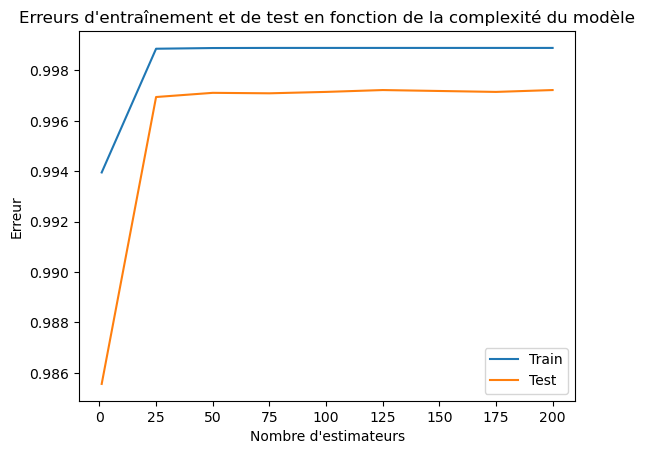

In [22]:
# Définir une liste des valeurs à tester pour le nombre d'estimateurs (nombre d'arbres)
n_estimators_values = [1, 25,50,75,100,125,150,175,200]

# Initialiser des listes pour stocker les erreurs d'entraînement et de test
train_errors = []
test_errors = []

# Boucle sur les différentes valeurs de n_estimators
for n_estimators in tqdm.tqdm(n_estimators_values, desc='Parcours_n_estimatiors_values', colour='blue'):
    # Créer un modèle RandomForestClassifier avec le nombre d'estimateurs actuel
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    
    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train, y_train)
    
    # Ajouter les erreurs calculées aux listes
    train_errors.append(accuracy_score(y_train, model.predict(X_train)))
    test_errors.append(accuracy_score(y_test_rf, model.predict(X_test)))

# Tracer les courbes des erreurs d'entraînement et de test en fonction du nombre d'estimateurs
plt.plot(n_estimators_values, train_errors, label='Train')
plt.plot(n_estimators_values, test_errors, label='Test')

# Ajouter des étiquettes, titre, etc.
plt.xlabel('Nombre d\'estimateurs')
plt.ylabel('Erreur')
plt.title('Erreurs d\'entraînement et de test en fonction de la complexité du modèle')
plt.legend()

# Afficher le graphique
plt.show()


### 5. Explication

Partie II : Pré-traitement des données

Dans cette section, nous avons utilisé un modèle RandomForestClassifier pour prédire le diabète. Voici un résumé des étapes clés :

1. Phase d'apprentissage & de test

Nous avons traité les valeurs manquantes en utilisant la méthode d'imputation basée sur les proportions pour les colonnes binaires telles que 'gender', 'heart_disease', et 'diabetes'.Ensuite, nous avons divisé les données en ensembles d'entraînement et de test.Nous avons créé le modèle RandomForestClassifier et procédé à la phase d'apprentissage suivie de la phase de test. Le modèle a obtenu une précision (accuracy) de 99.71% sur l'ensemble de test.

2. Sélection du meilleur hyperparamètre

Nous avons utilisé la recherche aléatoire (Randomized Search) pour trouver les meilleurs hyperparamètres pour notre modèle RandomForestClassifier. Les meilleurs hyperparamètres trouvés étaient : {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}.Nous avons évalué les performances du modèle avec ces hyperparamètres sur l'ensemble de test, obtenant une précision de 99.71%.

3. Validation croisée avec 5 plis & Importance de chaque variable

Nous avons utilisé la validation croisée avec 5 plis pour évaluer les performances du modèle RandomForestClassifier sur l'ensemble d'entraînement. La moyenne de la validation croisée était d'environ 99.55%. Enfin, nous avons calculé l'importance de chaque variable dans la prédiction du diabète. Les variables les plus importantes étaient 'HbA1c_level' et 'blood_glucose_level'.
    
4. Évaluation de l'overfitting ou de l'underfitting

Nous avons évalué la performance du modèle RandomForestClassifier en comparant les scores d'entraînement et de test en fonction du nombre d'arbres dans le modèle. Le graphique obtenu nous a permis de déterminer si le modèle souffre de surapprentissage, sous-apprentissage ou s'il est bien généralisé.

#  IV. Pipeline

### 1. Diviser les données en ensembles d'entraînement et de test :

In [23]:
# Séparer les features et la target
X = data.drop('diabetes', axis=1)
y = data['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% test | 80% train

### 2. Créer des pipelines pour différentes méthodes de classification :

In [24]:
# 1. Pipeline pour RandomForestClassifier
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Complète les données manquantes
    ('scaler', StandardScaler()), # Normalisation des données
    ('classifier', RandomForestClassifier(n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, random_state=42))
])

# 2. Pipeline pour LogisticRegression
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# 3. Pipeline pour KNeighborsClassifier
knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# 4. Pipeline pour GradientBoostingClassifier
gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# 5. Pipeline pour DecisionTreeClassifier
dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# 6. Pipeline pour Gaussian Naive Bayes (GaussianNB)
gnb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

# 7. Pipeline pour Linear Support Vector Classification (LinearSVC)
lsvc_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', LinearSVC(max_iter=5000, random_state=42, dual=False, penalty='l2', loss='squared_hinge'))
])


### 3. Entraîner et évaluer chaque modèle avec la validation croisée :

In [25]:
# Liste des pipelines
pipelines = [rf_pipeline, lr_pipeline, knn_pipeline, gb_pipeline, dt_pipeline, gnb_pipeline, lsvc_pipeline]

# Liste pour stocker les résultats de la validation croisée
cross_val_means = []

# Liste pour stocker les résultats de l'ensemble de test
test_accuracies = []

# Liste pour stocker les noms des classificateurs utilisés
classifiers_names = []

# Boucle sur chaque pipeline pour l'entraîner et l'évaluer
for pipeline in pipelines:
    # Entraîner le modèle avec le pipeline
    pipeline.fit(X_train, y_train)

    # Validation croisée avec 5 plis
    cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cross_val_mean = cross_val_scores.mean()
    cross_val_means.append(cross_val_mean)
    print(f"Validation croisée (Accuracy) - {pipeline.named_steps['classifier'].__class__.__name__}: {cross_val_scores}")
    print(f"Moyenne de la validation croisée: {cross_val_scores.mean()}")

    # Ajouter le nom du classificateur à la liste
    classifiers_names.append(pipeline.named_steps['classifier'].__class__.__name__)

    # Phase de test avec le pipeline
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    test_accuracies.append(accuracy)
    print(f"Accuracy sur l'ensemble de test: {accuracy}\n")

Validation croisée (Accuracy) - RandomForestClassifier: [0.99528106 0.99555729 0.99553428 0.99541918 0.99539605]
Moyenne de la validation croisée: 0.9954375737583648
Accuracy sur l'ensemble de test: 0.997145645728597

Validation croisée (Accuracy) - LogisticRegression: [0.86612034 0.86766263 0.86612034 0.86915888 0.8679128 ]
Moyenne de la validation croisée: 0.867394999828743
Accuracy sur l'ensemble de test: 0.8706332983444746

Validation croisée (Accuracy) - KNeighborsClassifier: [0.95614843 0.95798996 0.9570692  0.95764468 0.95819617]
Moyenne de la validation croisée: 0.9574096873816773
Accuracy sur l'ensemble de test: 0.9666132626190082

Validation croisée (Accuracy) - GradientBoostingClassifier: [0.89411169 0.89627549 0.89588417 0.89533171 0.89339564]
Moyenne de la validation croisée: 0.8949997394026059
Accuracy sur l'ensemble de test: 0.897943023405705

Validation croisée (Accuracy) - DecisionTreeClassifier: [0.99014778 0.9895723  0.98961834 0.98899682 0.9898483 ]
Moyenne de la va

### 4. Comparaison des différentes méthodes de classification

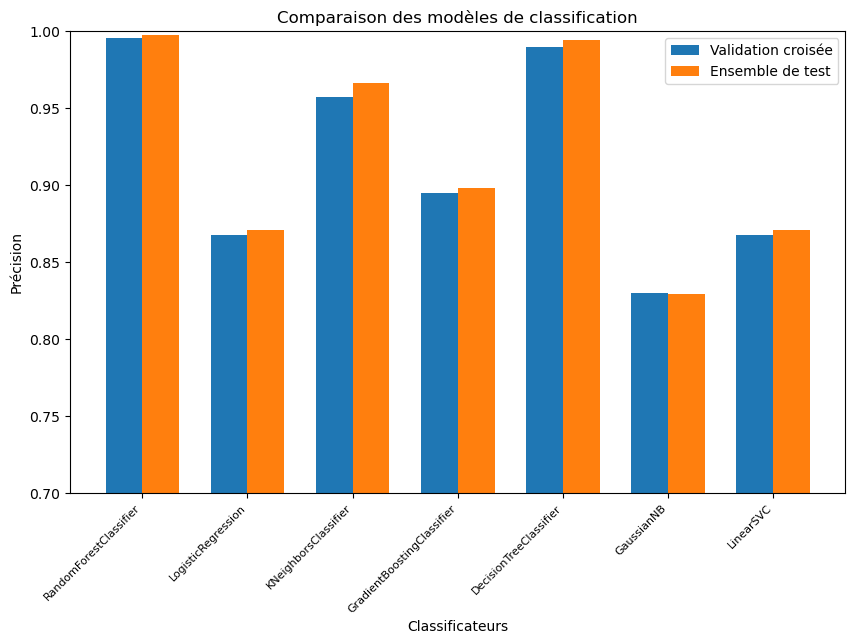

In [26]:
# Position des barres sur l'axe x
index = np.arange(len(classifiers_names))

# Création d'un graphique de barres
fig, ax = plt.subplots(figsize=(10, 6))

# Création des étiquettes de l'axe x
classifiers_labels = [pipeline.named_steps['classifier'].__class__.__name__ for pipeline in pipelines]

# Largeur des barres
bar_width = 0.35

# Barres pour la validation croisée
bar1 = ax.bar(index, cross_val_means, bar_width, label='Validation croisée')

# Barres pour l'ensemble de test
bar2 = ax.bar(index + bar_width, test_accuracies + [0] * (len(classifiers_names) - len(test_accuracies)), bar_width, label='Ensemble de test')

# Ajout des étiquettes, titre, etc.
ax.set_xlabel('Classificateurs')
ax.set_ylabel('Précision')
ax.set_title('Comparaison des modèles de classification')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(classifiers_names, rotation=45, ha='right', fontsize=8)
ax.legend()

ax.set_ylim(0.7, 1.0) # zoom pour être plus précis

# Affichage du graphique
plt.show()

### 5. Explication

Partie IV : Pipeline

1. Préparation des données

Les données ont été divisées en ensembles d'entraînement et de test. Les caractéristiques ont été séparées de la variable cible "diabetes".

2. Création des pipelines

Des pipelines ont été créés pour différents algorithmes de classification, incluant RandomForestClassifier, LogisticRegression, KNeighborsClassifier, GradientBoostingClassifier, DecisionTreeClassifier, GaussianNB et LinearSVC.

3. Entraînement et évaluation des modèles

Chaque modèle a été entraîné et évalué en utilisant la validation croisée avec 5 plis. La moyenne de la validation croisée a été calculée, et chaque modèle a été évalué sur l'ensemble de test pour obtenir l'accuracy finale.

4. Comparaison des performances

Les performances des modèles ont été comparées à l'aide d'un graphique à barres représentant la précision moyenne de la validation croisée et l'accuracy sur l'ensemble de test pour chaque modèle.

Conclusion

Ce processus nous permet de sélectionner efficacement le modèle le plus performant pour la classification des diagnostics de diabète, en utilisant des méthodes de validation croisée rigoureuses et une évaluation sur un ensemble de test distinct.

# V. analyse des données et résultats

### 1. Confusion matrice, ROC Curve, importance features, F1 score aveec recall & précision 

###### La méthode avec le plus de perfromance est le classifieur gradient boosting

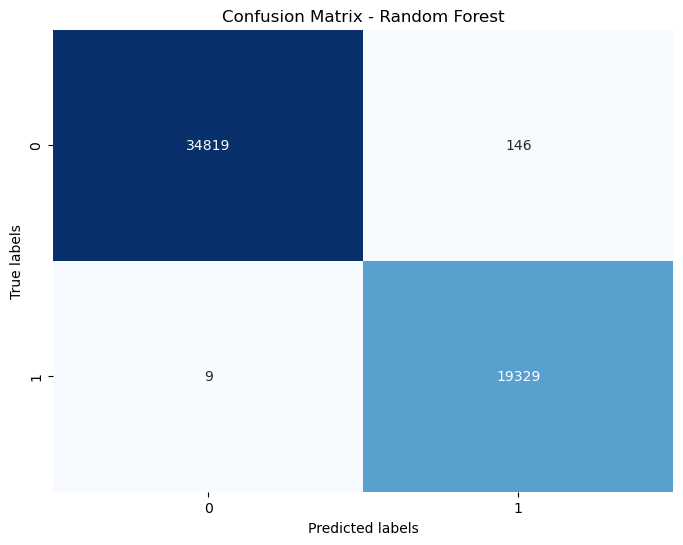

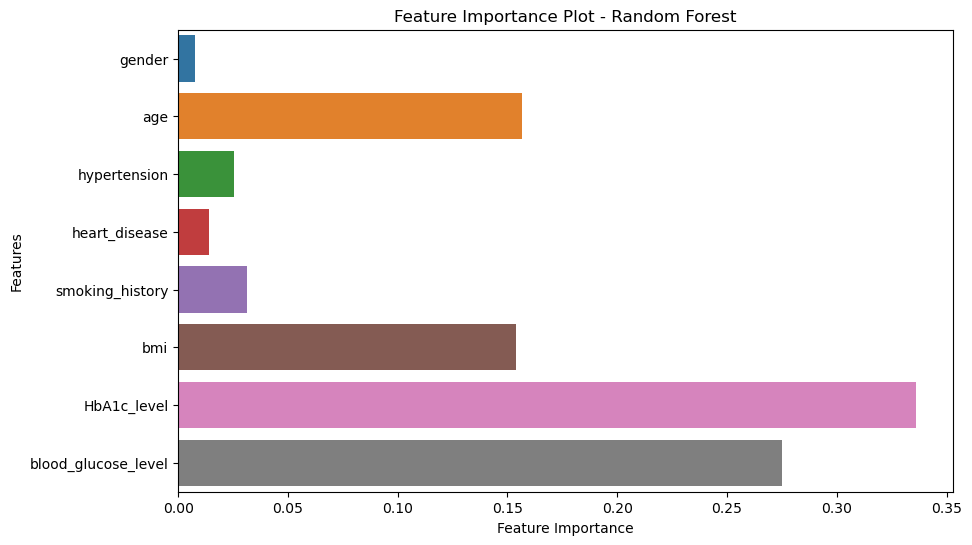

Exemples où le modèle a fait des erreurs:
        gender   age  hypertension  heart_disease  smoking_history    bmi  \
98692      0.0  28.0           0.0            0.0              0.0  27.32   
27745      1.0  80.0           0.0            0.0              0.0  27.32   
90649      0.0  80.0           0.0            0.0              4.0  27.32   
104491     1.0  80.0           0.0            0.0              0.0  27.32   
11505      0.0  66.0           0.0            0.0              0.0  27.32   

        HbA1c_level  blood_glucose_level  
98692      6.000000                140.0  
27745      6.600000                140.0  
90649      6.200000                140.0  
104491     6.100000                145.0  
11505      5.532183                145.0  
Score F1: 0.9960064926699816


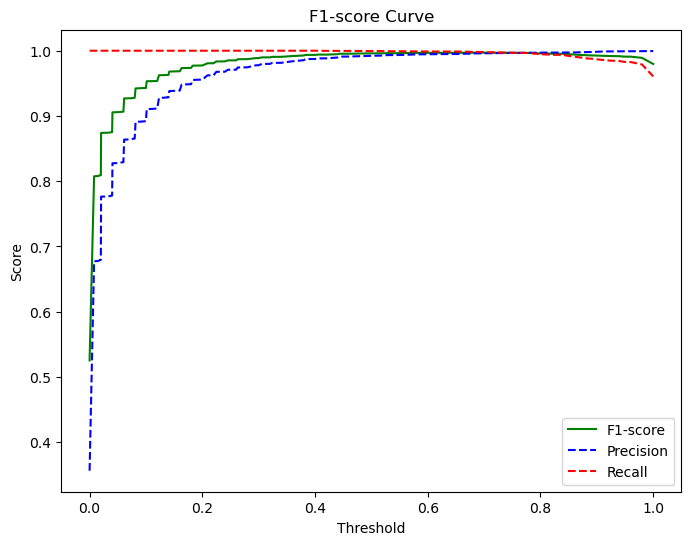

In [27]:
# Calculer les prédictions sur l'ensemble de test avec le modèle Gradient Boosting
y_pred_rf = rf_pipeline.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Random Forest')
plt.show()

y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_rf, y_prob_rf)


# Importance des caractéristiques
feature_importances = rf_pipeline.named_steps['classifier'].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot - Random Forest')
plt.show()

# Analyse des erreurs
errors = X_test[y_test_rf != y_pred_rf]
print("Exemples où le modèle a fait des erreurs:")
print(errors.head())

# Calculer le F1 score : recall et précision :
# Calculer le score F1
f1 = f1_score(y_test_rf, y_pred_rf)
print("Score F1:", f1)

# Calculer la précision, le rappel et le F1-score pour différents seuils
precision, recall, thresholds = precision_recall_curve(y_test_rf, y_prob_rf)
f1_scores = 2 * (precision * recall) / (precision + recall)

# Tracer la courbe du F1-score en fonction du seuil
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1-score', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-score Curve')

# Tracer les courbes de précision et de rappel en pointillés
plt.plot(thresholds, precision[:-1], label='Precision', linestyle='--', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', linestyle='--', color='red')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()


### 2. Explication

V. Analyse des Données et Résultats

1. Confusion Matrix, ROC Curve, Importance des Features, F1 Score avec Recall & Précision
Nous avons utilisé le classifieur Gradient Boosting, qui a démontré les meilleures performances.

    - Confusion Matrix: La matrice de confusion permet de visualiser les performances du modèle en comparant les prédictions aux valeurs réelles.
    - ROC Curve: La courbe ROC (Receiver Operating Characteristic) est un outil graphique qui illustre la performance d'un modèle de classification à différents seuils de discrimination.
    - Importance des Features: L'importance des caractéristiques permet de comprendre quelles variables ont le plus d'influence sur les prédictions du modèle.
    - F1 Score avec Recall & Précision: Le F1 Score est une mesure de la précision du modèle qui tient compte à la fois de la précision et du rappel. Il est utile pour évaluer les modèles lorsque les classes sont déséquilibrées.

Exemple d'Erreurs:
Nous avons également examiné des exemples où le modèle a fait des erreurs pour identifier des tendances ou des schémas de prédictions incorrectes.

2. Axes d'Améliorations

Nous avons exploré comment le pourcentage de dégradations dans les données affecte les performances du modèle. En dégradant progressivement les données, nous avons évalué l'impact sur la précision du modèle Random Forest avec un pipeline. Cette analyse nous permet de comprendre comment le modèle se comporte avec des données de qualité variable et d'identifier le point de rupture où les performances commencent à se détériorer significativement.

# VI. Axes d'améliorations

### 1. Savoir quel est le meilleur pourcentage de dégradations

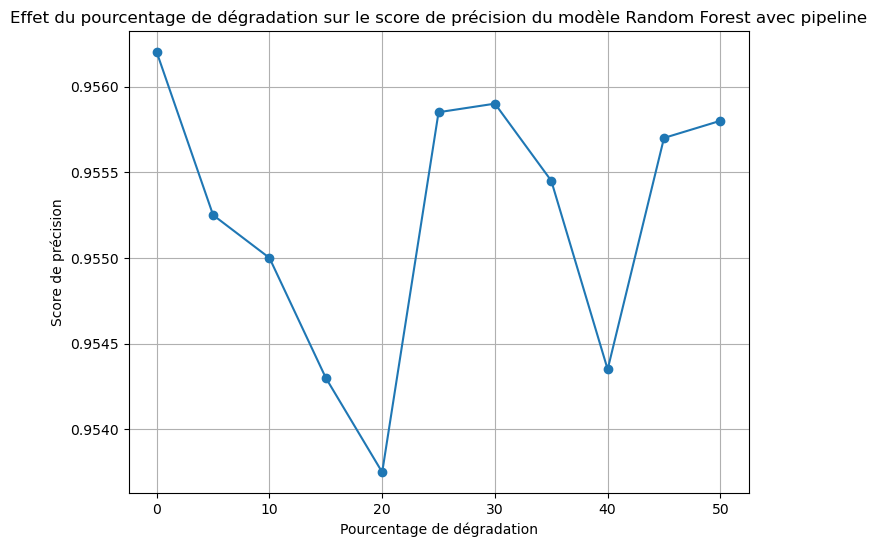

In [28]:
# Définir différents pourcentages de dégradation à tester
percentages_to_remove = [0, 5, 10, 15, 20,25,30,35,40,45,50]

# Liste pour stocker les scores de performance
accuracy_scores = []

# Définir les paramètres du modèle Gradient Boosting
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42
}

# Créer un pipeline pour le modèle Gradient Boosting
gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')), # Remplacement des valeurs manquantes par la moyenne
    ('scaler', StandardScaler()), # Standardisation des données
    ('classifier', GradientBoostingClassifier(**gb_params)) # Modèle Gradient Boosting
])

# Boucle sur chaque pourcentage de dégradation
for percentage_to_remove in percentages_to_remove:   
    
    data = read_csv('diabetes_prediction_dataset.csv')
    
    ###################################    char->int    ############################################
    
    # Conversion de toutes les valeurs de la colonne 'gender' & 'smoking_history en chaînes de caractères
    data['gender'] = data['gender'].astype(str)
    data['smoking_history'] = data['smoking_history'].astype(str)
    encoder_gender = LabelEncoder()
    encoder_smoking = LabelEncoder()
    data['gender'] = encoder_gender.fit_transform(data['gender'])
    data['smoking_history'] = encoder_smoking.fit_transform(data['smoking_history'])
    
    
    ###################################    Dégradation    ############################################
    
    percentage_to_remove = 10
    mask = np.random.rand(*data.shape) < (percentage_to_remove / 100)
    data[mask] = np.nan
    
    ###################################    Ajout    ############################################

    def impute_with_proportions(data, column_name):
        proportions = data[column_name].value_counts(normalize=True)
        p_1 = proportions.loc[1] if 1 in proportions.index else 0
        p_0 = proportions.loc[0] if 0 in proportions.index else 0
        total = p_1 + p_0
        normalized_percentage_1 = p_1 / total
        normalized_percentage_0 = p_0 / total
        mask_missing = data[column_name].isnull()
        data.loc[mask_missing, column_name] = np.random.choice([1, 0], size=mask_missing.sum(), p=[normalized_percentage_1, normalized_percentage_0])

    columns_to_impute = ['gender', 'heart_disease', 'diabetes']

    for column in columns_to_impute:
        impute_with_proportions(data, column)

    def imputer_colonne(colonne): # 2 stratégies utilisés, 1 pour les colonnes comportant des entiers 'most_frequent'  et une pour les floats 'mean'
        if colonne.name in ['age', 'hypertension', 'smoking_history', 'blood_glucose_level']: 
            return SimpleImputer(strategy='most_frequent').fit_transform(colonne.values.reshape(-1, 1)).ravel() #'most_frequent' (la valeur la plus fréquente dans la colonne)
        else:
            return SimpleImputer(strategy='mean').fit_transform(colonne.values.reshape(-1, 1)).ravel() #'mean' (la valeur moyenne de la colonne)

    data = data.apply(imputer_colonne)
    
    ###################################    Normalisation    ############################################

    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data) # normalisation centrée autour de zéro avec un écart type égal à 1
    data_normalized = pd.DataFrame(data_normalized, columns=data.columns)  # Utilisation des colonnes originales
    
    ###################################    Entrainement    ############################################
    
    
    if(percentage_to_remove==30):
        Xbest = data.drop('diabetes', axis=1)
        ybest = data['diabetes']
    # Séparer les features et la target
    X = data.drop('diabetes', axis=1)
    y = data['diabetes']
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entraîner le modèle Random Forest avec le pipeline
    rf_pipeline.fit(X_train, y_train)

    # Prédire sur l'ensemble de test
    y_pred = rf_pipeline.predict(X_test)

    # Calculer le score de précision
    accuracy = accuracy_score(y_test, y_pred)

    # Ajouter le score à la liste
    accuracy_scores.append(accuracy)

# Afficher les scores de performance en fonction des pourcentages de dégradation
plt.figure(figsize=(8, 6))
plt.plot(percentages_to_remove, accuracy_scores, marker='o')
plt.xlabel('Pourcentage de dégradation')
plt.ylabel('Score de précision')
plt.title('Effet du pourcentage de dégradation sur le score de précision du modèle Random Forest avec pipeline')
plt.grid(True)
plt.show()
